# Problem Set 3

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, LeaveOneOut, KFold
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, ElasticNet 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.tree import export_graphviz, DecisionTreeRegressor, plot_tree
from sklearn.svm import SVC
import graphviz

For the next problem we will be using the `Carseats` data set that is available on learningsuite. Load the data and convert the text variables into dummies so that we can use them in the data. Pandas has a function called `get_dummies` that you might want to use.

In [5]:
df = pd.read_csv(r'C:\Users\ben1c\Projects\Econ 484\Homework\Carseats.csv', index_col=0)

In [6]:
df = pd.get_dummies(df)
df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Bad,ShelveLoc_Good,ShelveLoc_Medium,Urban_No,Urban_Yes,US_No,US_Yes
1,9.50,138,73,11,276,120,42,17,1,0,0,0,1,0,1
2,11.22,111,48,16,260,83,65,10,0,1,0,0,1,0,1
3,10.06,113,35,10,269,80,59,12,0,0,1,0,1,0,1
4,7.40,117,100,4,466,97,55,14,0,0,1,0,1,0,1
5,4.15,141,64,3,340,128,38,13,1,0,0,0,1,1,0


In [7]:
df.columns

Index(['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'Age', 'Education', 'ShelveLoc_Bad', 'ShelveLoc_Good',
       'ShelveLoc_Medium', 'Urban_No', 'Urban_Yes', 'US_No', 'US_Yes'],
      dtype='object')

Now that the data has only numeric columns, we can proceed to the analysis.  
Use `Sales` as the outcome variable  
(a) Split the data set into a training set and a test set.  
(b) Fit a regression tree to the training set.  What test MSE do you obtain?  

    -The test MSE on the basic tree is 3.8

(c) Use cross-validation in order to determine the optimal level of tree complexity. Does pruning the tree improve the test MSE? Plot a tree with a depth of 3, and interpret the results.

    -Pruning the tree did not help the training or test MSE so it probably is too low of a depth that I tried.
    -The tree diagram shows where the model has learned to split the data to separate it into the different outcomes that it has learned.
   
(d) Use the bagging approach in order to analyze this data. What test MSE do you obtain? Look at the feature importances attribute of your model object to determine which variables are most important.

    -Bagging produced a training MSE of 2.8
    -It looks like Price, Shelve_Good, Age and Shelve_Bad are most important
    
(e) Use random forests to analyze this data. What test MSE do you obtain? Look at the feature importances attribute of your model objec function to determine which variables are most important. Describe the effect of m, the number of variables considered at each split, on the error rate obtained.

    -After running it with max_features equally auto, log2, sqrt, and 1 the best test MSE was obtained with the auto or looking at n features

In [8]:
# A
features = ['CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'Age', 'Education', 'ShelveLoc_Bad', 'ShelveLoc_Good',
       'ShelveLoc_Medium', 'Urban_No', 'Urban_Yes', 'US_No', 'US_Yes']

X = pd.DataFrame(df, columns=features)
y = pd.Series(df['Sales'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

# B
dtr = DecisionTreeRegressor()

dtr.fit(X_train, y_train)
y_pred_train = dtr.predict(X_train)
y_pred_test = dtr.predict(X_test)
print("Basic Tree MSE:")
print("Train Accuracy: {}\tTest Accuracy: {}".format(mean_squared_error(y_train, y_pred_train),
                                           mean_squared_error(y_test, y_pred_test)))

Basic Tree MSE:
Train Accuracy: 0.0	Test Accuracy: 3.8422272727272735


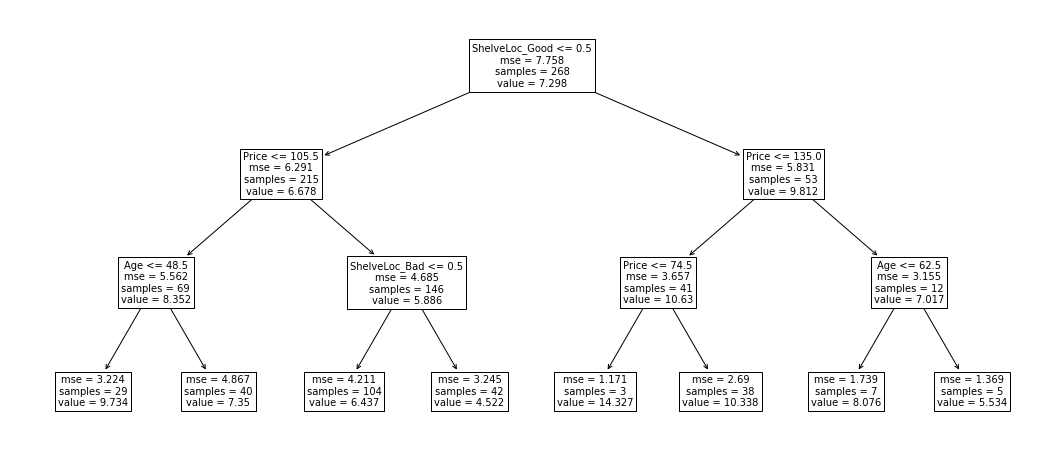

In [9]:
# C
dtr = DecisionTreeRegressor(max_depth=3)
dtr.fit(X_train, y_train)

# plot the graph!
plt.figure(figsize=(18, 8))
plot = plot_tree(dtr,
          feature_names = X_test.columns,
          max_depth = 3)     

In [10]:
gridsearch = GridSearchCV(dtr, {'max_depth': [1, 3, 5, 7, 9]}, cv=3)

gridsearch.fit(X_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_))


y_pred_train = gridsearch.predict(X_train)
y_pred_test = gridsearch.predict(X_test)
print("GridSearch MSE:")
print("Train Accuracy: {}\tTest Accuracy: {}".format(mean_squared_error(y_train, y_pred_train),
                                           mean_squared_error(y_test, y_pred_test)))

Best Params: {'max_depth': 5}
GridSearch MSE:
Train Accuracy: 1.9915580288317976	Test Accuracy: 4.802839321569946


c:\users\ben1c\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Bagging Regressor MSE:
Train Accuracy: 0.5110320858208957	Test Accuracy: 2.657114159090909


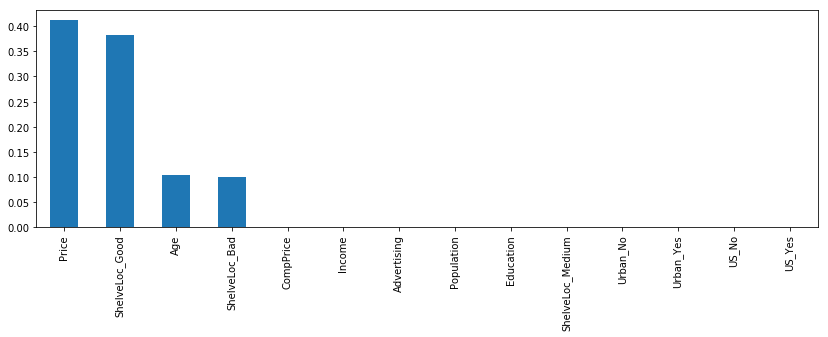

In [11]:
br = BaggingRegressor()
br.fit(X_train, y_train)
y_pred_train = br.predict(X_train)
y_pred_test = br.predict(X_test)
print("Bagging Regressor MSE:")
print("Train Accuracy: {}\tTest Accuracy: {}".format(mean_squared_error(y_train, y_pred_train),
                                           mean_squared_error(y_test, y_pred_test)))

feature_imp = sorted(list(zip(X.columns, dtr.feature_importances_)), key=lambda x: x[1], reverse=True)
pd.Series([x[1] for x in feature_imp[:]], index=[x[0] for x in feature_imp[:]]).plot(kind='bar', figsize=(14, 4))



Random Forest MSE:
Train Accuracy: 0.5888218992537315	Test Accuracy: 2.889510371212122


c:\users\ben1c\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


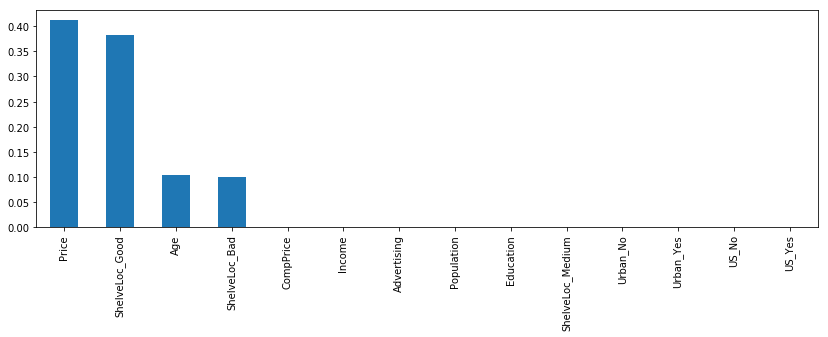

In [12]:
rfr = RandomForestRegressor(max_features='auto')
rfr.fit(X_train, y_train)
y_pred_train = rfr.predict(X_train)
y_pred_test = rfr.predict(X_test)
print("Random Forest MSE:")
print("Train Accuracy: {}\tTest Accuracy: {}".format(mean_squared_error(y_train, y_pred_train),
                                           mean_squared_error(y_test, y_pred_test)))

feature_imp = sorted(list(zip(X.columns, dtr.feature_importances_)), key=lambda x: x[1], reverse=True)
pd.Series([x[1] for x in feature_imp[:]], index=[x[0] for x in feature_imp[:]]).plot(kind='bar', figsize=(14, 4))



We now use boosting to predict Log Salary in the `Hitters` data set.  
(a) Remove the observations for whom the salary information is unknown, and then log-transform the salaries and use that as the outcome variable. Be sure to not incluide the old salary variable as a predictor  
(b) Create a training set consisting of 200 observations, and a test set consisting of the remaining observations.  
(c) Perform boosting on the training set with 1,000 trees for a range of values of the shrinkage parameter λ. Produce a plot with different shrinkage values on the x-axis and the corresponding training set MSE on the y-axis. Add a curve with different shrinkage values on the x-axis and the corresponding test set MSE on the y-axis. The shrinkage parameter is often referred to as the learning rate   
(d) Compare the test MSE of boosting to the test MSE that results from applying two of the regression approaches seen in Chapters 3 and 6. Those are the chapters on OLS and penalized regression.  

    -The Test MSE is better for boosting depending on what learning rate you use. If you choose the best learning rate roughly .05 then Boosting will better otherwise the Linear Models perform better
    
(e) Which variables appear to be the most important predictors in the boosted model?  
(f) The default for base estimator is a Decision Tree with a maximum depth of 3. Is that the optimal depth? Justify your response.

    -GridsearchCV said that max_depth=3 was the best parameters for obtaining the lowest Test MSE
    
(g) Now apply bagging to the training set. What is the test set MSE for this approach?  
    - The MSE for bagging is roughly .28

In [13]:
df1 = pd.read_csv(r'C:\Users\ben1c\Projects\Econ 484\Homework\Hitters.csv')

df1.dropna(subset=['Salary'], inplace=True)
df1['Salary'] = np.log(df1['Salary'])

df1 = pd.get_dummies(df1)
df1.head()
df1.columns

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors', 'Salary', 'League_A', 'League_N', 'Division_E', 'Division_W',
       'NewLeague_A', 'NewLeague_N'],
      dtype='object')

In [14]:
X = pd.DataFrame(df1, columns=['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors', 'League_A', 'League_N', 'Division_E', 'Division_W',
       'NewLeague_A', 'NewLeague_N'])

y = df1['Salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=200, random_state=42)

In [15]:
boost = GradientBoostingRegressor(n_estimators=1000)
r = range(10)
lr = [10**(-(r[i])) for i in r]
msetrain = []
msetest = []

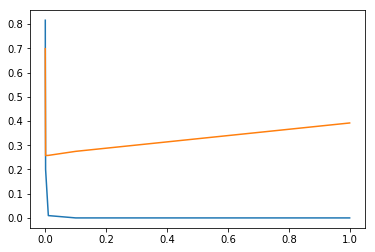

In [16]:
for i in lr:
    boost = GradientBoostingRegressor(n_estimators=1000, learning_rate=i)
    boost.fit(X_train, y_train)
    y_pred_train = boost.predict(X_train)
    y_pred_test = boost.predict(X_test)
    msetrain.append(mean_squared_error(y_train, y_pred_train))
    msetest.append(mean_squared_error(y_test, y_pred_test))
    
               
sns.lineplot(lr, msetrain)               
sns.lineplot(lr, msetest)               

In [17]:
linearmodel = LinearRegression()
linearmodel = linearmodel.fit(X_train, y_train)
cross = cross_validate(linearmodel, X, y, cv=3, scoring='neg_mean_squared_error', return_estimator=True)

print('Linear MSE:', -cross['test_score'].mean())

lasso = Lasso()
lasso = lasso.fit(X_train, y_train)
cross = cross_validate(lasso, X, y, cv=3, scoring='neg_mean_squared_error', return_estimator=True)

print('Lasso MSE:', -cross['test_score'].mean())

Linear MSE: 0.43074331126029675
Lasso MSE: 0.42258729353069563


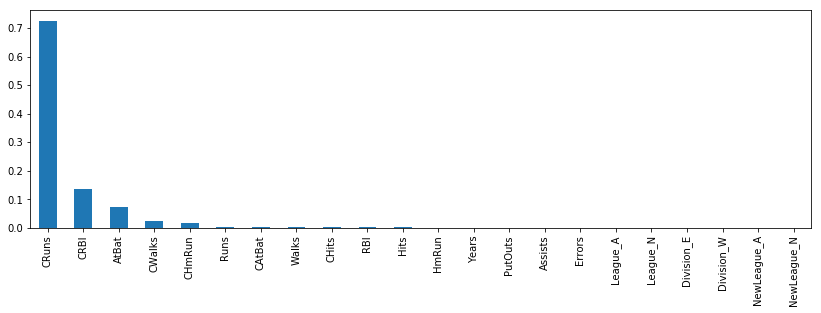

In [18]:
feature_imp = sorted(list(zip(X.columns, boost.feature_importances_)), key=lambda x: x[1], reverse=True)
pd.Series([x[1] for x in feature_imp[:]], index=[x[0] for x in feature_imp[:]]).plot(kind='bar', figsize=(14, 4))

In [19]:
gridsearch = GridSearchCV(dtr, {'max_depth': [1, 3, 5, 7, 9]}, cv=3)
gridsearch.fit(X_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_))


y_pred_train = gridsearch.predict(X_train)
y_pred_test = gridsearch.predict(X_test)
print("GridSearch MSE:")
print("Train Accuracy: {}\tTest Accuracy: {}".format(mean_squared_error(y_train, y_pred_train),
                                           mean_squared_error(y_test, y_pred_test)))

Best Params: {'max_depth': 5}
GridSearch MSE:
Train Accuracy: 0.05267975001736455	Test Accuracy: 0.35487579874354347


c:\users\ben1c\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [20]:
br = BaggingRegressor()
br.fit(X_train, y_train)
y_pred_train = br.predict(X_train)
y_pred_test = br.predict(X_test)
print("Bagging Regressor MSE:")
print("Train Accuracy: {}\tTest Accuracy: {}".format(mean_squared_error(y_train, y_pred_train),
                                           mean_squared_error(y_test, y_pred_test)))

Bagging Regressor MSE:
Train Accuracy: 0.035325277495062306	Test Accuracy: 0.2895426996138626


In this problem, you will use support vector approaches in order to predict whether a given car gets high or low gas mileage based on the Auto data set.  
(a) Create a binary variable that takes on a 1 for cars with gas mileage above the median, and a 0 for cars with gas mileage below the median. Should we continue using gas mileage as a predictor if this is our outcome?  
    -Well if we do it will be a perfect predictor of whether it is above median or not, so we probably shouldn't use it
    
(b) Fit a support vector classifier to the data with various values of cost, in order to predict whether a car gets high or low gas mileage. Report the cross-validation errors associated with different values of this parameter. Comment on your results.  
    -It performs really bad when C is less than .1 but once it passes 1 it appears to only have minimal issues
    -C (Train Accuracy, Test Accuracy)-> .01 (.54, .49), .1 (.9, .87), 1 (.9, .88), 10 (.91, .88)
    
(c) Now repeat (b), this time using SVMs with radial and polynomial basis kernels, with different values of gamma and degree and cost. Comment on your results. What parameters yield the best results?
    -Gridsearching through these different values helped us get to an  test accuracy score .89 which is slightly better than what we were getting before 

In [21]:
df = pd.read_csv(r'C:\Users\ben1c\Projects\Econ 484\Homework\Auto-Copy1.csv')
df = df.replace({'?': '0'})
df['horsepower'] = df['horsepower'].astype(float)
mean = df.horsepower.mean()
df = df.replace({0.0 : mean})
df['mpg'] = np.where(df['mpg'] > df.mpg.median(), 1, 0)
df.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin', 'name'],
      dtype='object')

In [22]:
X = pd.DataFrame(df, columns=['cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin'])
y = df['mpg']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=200, random_state=42)

Scale the Data

In [23]:
# Compute the minimum value per feature on the training set
min_on_training = X_train.min(axis=0)
# Compute the range of each feature (max - min) on the training set
range_on_training = (X_train - min_on_training).max(axis=0)

# subtract the min, divide by range
# afterward, min=0 and max=1 for each feature
X_train_scaled = (X_train - min_on_training) / range_on_training
X_test_scaled = (X_test - min_on_training) / range_on_training

In [24]:
svc = SVC()
gridsearch = GridSearchCV(svc, {'C': [1]}, cv=3) # .01 (.54, .49), .1 (.9, .87), 1 (.9, .88), 10 (.91, .88)
gridsearch.fit(X_train_scaled, y_train)
print("Best Params: {}".format(gridsearch.best_params_))

print("Accuracy on training set: {:.3f}".format(gridsearch.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(gridsearch.score(X_test_scaled, y_test)))

Best Params: {'C': 1}
Accuracy on training set: 0.905
Accuracy on test set: 0.888


c:\users\ben1c\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\ben1c\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\ben1c\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureW

In [25]:
svc = SVC()
gridsearch = GridSearchCV(svc, {'C': [.01, .1, 1, 10],
                               'degree':[1, 2, 5],
                               'kernel':['rbf', 'poly'],
                               'gamma':['auto', 'scale'],}, cv=3) 
gridsearch.fit(X_train_scaled, y_train)
print("Best Params: {}".format(gridsearch.best_params_))

print("Accuracy on training set: {:.3f}".format(gridsearch.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(gridsearch.score(X_test_scaled, y_test)))

Best Params: {'C': 10, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy on training set: 0.965
Accuracy on test set: 0.898


c:\users\ben1c\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Number 3 from the handwritten portion

The group includes Tausha Morris, Michael Friedman, Adam Chappell, and Ben Chapdelaine

How long will a renter choose to rent out a location on Neighbor.com?

Our data comes from Neighbor, the "AirBnb" of Storage, which is a local startup for storage spaces on a peer to peer platform. We were given access to the company's databases with predictors including:

Storage Type, Storage Price, Demographic Info, Zipcode of Storage, What the person is storing, etc.

We intend to predict length of reservation.

In [41]:
listings = pd.read_csv(r'C:\Users\ben1c\Projects\Econ 484\Homework\listings.csv')

In [42]:
# Creates new column with Description Length Boolean
listings['Description Length'] = np.where(listings['summary'].str.len()>=30, '1', '0')

# Creates new column with Title Length Boolean
listings['Title Length'] = np.where((listings['listing_name'].str.len()>=10), 1, 0)

# Create Storage Type Category
listings['Storage Type'] = listings['storage_type'].values

# Create Accessibility Category
listings['Accessibility'] = listings['access'].values

# Create Price Per Square Ft
listings['Price Per SQFT'] = (listings['monthly_price'].values)/(listings['width'].values * listings['length'])

# Create Day Posted
listings['Day Posted'] = pd.to_datetime(listings['created_at']).dt.dayofweek

# Create Month Posted
listings['Month Posted'] = pd.to_datetime(listings['created_at']).dt.month

# Create Reserved Status
# listings = listings.assign(Reserved=listings.id.isin(reservations.listing_id).astype(int))

In [48]:
finaldf = pd.DataFrame()
# finaldf['Listing-ID'] = listings['id_x']
finaldf['Accessibility'] = listings['Accessibility']
finaldf['Storage Type'] = listings['Storage Type']
finaldf['Title Length'] = listings['Title Length']
finaldf['Description Length'] = listings['Description Length']
finaldf['Indoor'] = listings['indoor']
finaldf['Day Posted'] = listings['Day Posted']
finaldf['Month Posted'] = listings['Month Posted']
# finaldf['Photos of the Space'] = listings['Frequency']
# finaldf['Streetview'] = listings['streetview']
# finaldf['Discount'] = listings['Discount']
finaldf = pd.get_dummies(finaldf)
# finaldf.describe().round(1)

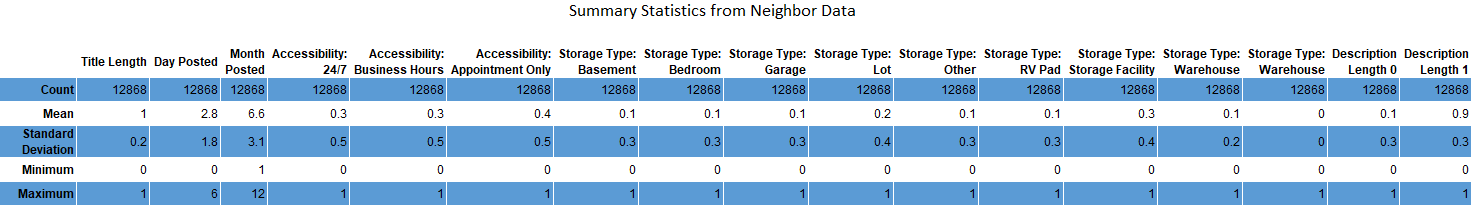

Most of the data is binary so the summary stats aren't super helpful so far.

We will most likely use Linear Regression, a from of a tree regression, and maybe a neural network.